In [37]:
import wandb


WANDB_PROJECT_NAME = "NoduleClassification"

#87e3b4f079c5a73e70e9ebd3bda9dc48ee553d9f
wandb.login(key='87e3b4f079c5a73e70e9ebd3bda9dc48ee553d9f')


import tempfile

from monai.visualize.utils import matshow3d, blend_images
from monai.data import CacheDataset, ThreadDataLoader
from monai.transforms import (
    Compose,
    LoadImaged,
    ScaleIntensityRanged,
    Orientationd,
    Spacingd,
    CropForegroundd,
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd,
    EnsureTyped,
    BorderPad,
    SaveImaged,
    RandRotated,
    Rotated
)

from monai.data import  decollate_batch

import matplotlib.pyplot as plt
from basic_unet import BasicUNet
from monai.inferers import sliding_window_inference

from monai.losses import DiceCELoss, FocalLoss

from monai.metrics import DiceMetric, ROCAUCMetric,LossMetric

from torch.optim.lr_scheduler import ReduceLROnPlateau

from monai.transforms import AsDiscrete

from tqdm import tqdm

from nodule_transforms.LoadArterysMaskd import LoadArterysMaskd
from nodule_transforms.AddCustomerMetadatad import AddCustomerMetadatad
from nodule_transforms.CropToNoduled import CropToNoduled
from nodule_transforms.EncodeClassIntoMask import EncodeClassIntoMask

import os
import torch
import numpy as np
import pandas as pd


from data_tools.datatools import load_cancer_nodules_datalist, split_data, balance_and_split_data


# Save random seed
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

directory = './monai_data'
if not os.path.exists(directory):
    os.makedirs(directory)
    
root_dir = tempfile.mkdtemp() if directory is None else directory
cache_dir = './training_cache'

CANCER_NODULES_DATASET_DIR = '/media/vlermakov/data/UCSDNodules/Metastatic/'
#PRE_PROCESSED_DIRECTORY = '/home/vlermakov/Development/Nodules/Nodule-Detection-LUNA2016/processed_data_full_range/'
PRE_PROCESSED_SUBFOLDER = '/home/vlermakov/Development/Nodules/Nodule-Detection-LUNA2016/processed_data_full_range_075mm_fixed/'
#PRE_PROCESSED_SUBFOLDER = './processed_data_unetr_range/'
#PRE_PROCESSED_SUBFOLDER = './processed_data_full_range_1mm/'


dataset = pd.read_csv(os.path.join(CANCER_NODULES_DATASET_DIR, "dataset.csv"), dtype={'MRN': str})

# Ignore class = 1
#dataset = dataset[dataset.label != 1]

# All class 2 set to class 1
dataset.loc[dataset.label == 2, 'label'] = 1

datalist = load_cancer_nodules_datalist(CANCER_NODULES_DATASET_DIR, PRE_PROCESSED_SUBFOLDER)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


processed_scans = []
unprocessed_scans = []

n_processed = 0
for p in datalist:
    if p['pre_processed']:
        n_processed += 1 
        processed_scans.append(p)
    else:
        unprocessed_scans.append(p)

#train_data_list, val_data_list = balance_and_split_data(processed_scans,0.8)
val_data_list = processed_scans
train_df = pd.DataFrame(train_data_list)
val_df = pd.DataFrame(val_data_list)

val_transforms = Compose(
    [
        LoadImaged(keys=["image"], ensure_channel_first=True, image_only=False),
        LoadImaged(keys=["mask"], ensure_channel_first=True, image_only=False),
    ]
)


train_data_list, val_data_list = balance_and_split_data(processed_scans,0.8)

val_ds = CacheDataset(data=val_data_list, transform=val_transforms, cache_num=len(val_data_list), cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)



wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/vlermakov/.netrc


Processing MRN 211 Phonetic_ID Fesaho
Processing MRN 210 Phonetic_ID Quabemo
Processing MRN 209 Phonetic_ID Quekelurn
Processing MRN 208 Phonetic_ID Jufueklip
Processing MRN 207 Phonetic_ID Moyabdof
Processing MRN 206 Phonetic_ID Tudipi
Processing MRN 205 Phonetic_ID Nousisig
Processing MRN 204 Phonetic_ID Budueyi
Processing MRN 203 Phonetic_ID Jenuda
Processing MRN 202 Phonetic_ID Cretaha
Processing MRN 201 Phonetic_ID Pejaru
Processing MRN 200 Phonetic_ID Barethue
Processing MRN 199 Phonetic_ID Miekefre
Processing MRN 198 Phonetic_ID Labfaljon
Processing MRN 196 Phonetic_ID Togepel
Processing MRN 195 Phonetic_ID Diclama
Processing MRN 194 Phonetic_ID Worowof
No json file found for patch_id_stub 603d4040eebdcd0a54995523-4a146fafa3461460
Processing MRN 193 Phonetic_ID Loomako
Processing MRN 192 Phonetic_ID Puguxiep
Processing MRN 191 Phonetic_ID Alnpatik
Processing MRN 190 Phonetic_ID Beelelu
Processing MRN 189 Phonetic_ID Omlolit
Processing MRN 189 Phonetic_ID Pihoko
Processing MRN 18

Processing MRN 38 Phonetic_ID Tidona
Processing MRN 37 Phonetic_ID Kesuci
Processing MRN 36 Phonetic_ID Masede
Processing MRN 35 Phonetic_ID Hukliley
Processing MRN 34 Phonetic_ID Hesora
Processing MRN 33 Phonetic_ID Kajalol
Processing MRN 32 Phonetic_ID Jugaso
Processing MRN 31 Phonetic_ID Jesbernan
Processing MRN 30 Phonetic_ID Lihamu
Processing MRN 29 Phonetic_ID Lorique
Processing MRN 28 Phonetic_ID Gojequa
Processing MRN 27 Phonetic_ID Hehuji
Processing MRN 26 Phonetic_ID Frequalad
Processing MRN 25 Phonetic_ID Nuborif
Processing MRN 24 Phonetic_ID Figooso
Processing MRN 23 Phonetic_ID Hilescuet
Processing MRN 22 Phonetic_ID Fabacou
Processing MRN 21 Phonetic_ID Pokuemo
Processing MRN 20 Phonetic_ID Sracaqua
Processing MRN 19 Phonetic_ID Hakingques
Processing MRN 18 Phonetic_ID Tuerekom
Processing MRN 17 Phonetic_ID Swofeku
Processing MRN 16 Phonetic_ID Ridine
Processing MRN 15 Phonetic_ID Mohuteg
Patch ID nan is not a string
Processing MRN 14 Phonetic_ID Rakajid
Processing MRN 13

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.52it/s]


In [38]:


unet_model = BasicUNet(
    #img_size=(96, 96, 96),
    in_channels=1,
    out_channels=14
    #feature_size=48,
    #use_checkpoint=True,
).to(device)


# Define a custom model that will take SwinUNETR and pass its hidden layer to a fully connected layer
class BasicUNETRWithFC(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.fc = torch.nn.Linear(256, 1)

        # Average pooling to reduce the size of the image
        self.pooling = torch.nn.AvgPool3d(kernel_size=6, stride=1)

    def forward(self, x):
        logit_map, hidden_layers = self.model(x)
        x = self.pooling(hidden_layers).view(-1, 256)
        x = self.fc(x)
        classification_output = torch.nn.functional.sigmoid(x).to(dtype=torch.float32)

        

        return logit_map, classification_output

model = BasicUNETRWithFC(unet_model).to(device)


BasicUNet features: (32, 32, 64, 128, 256, 32).


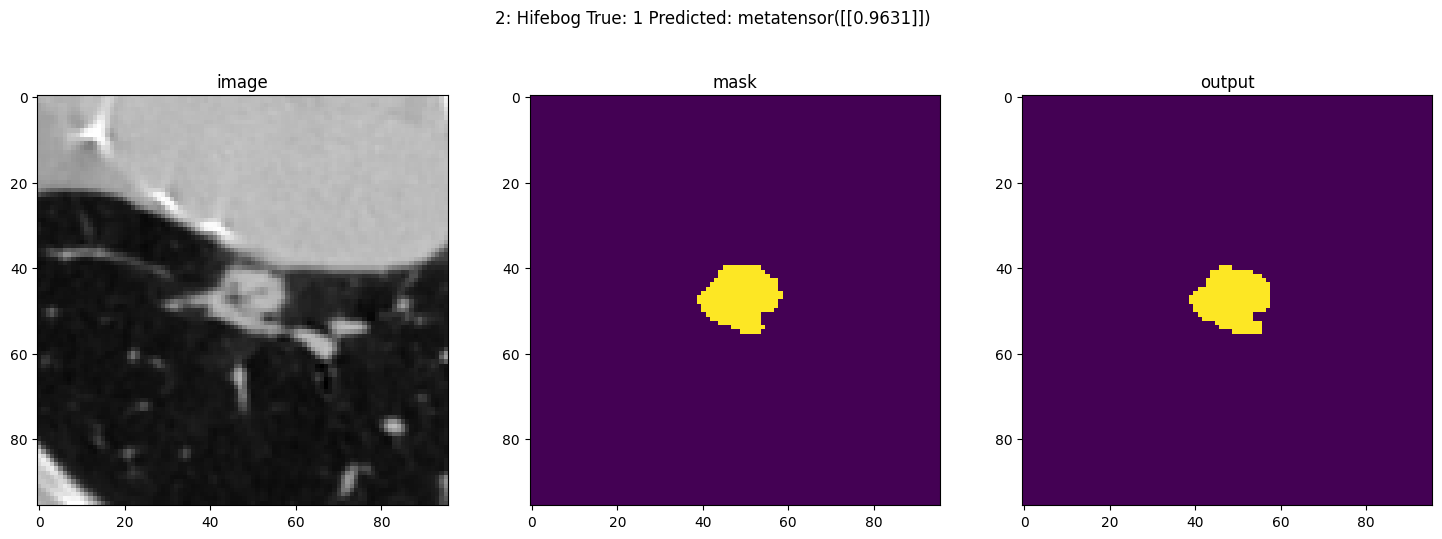

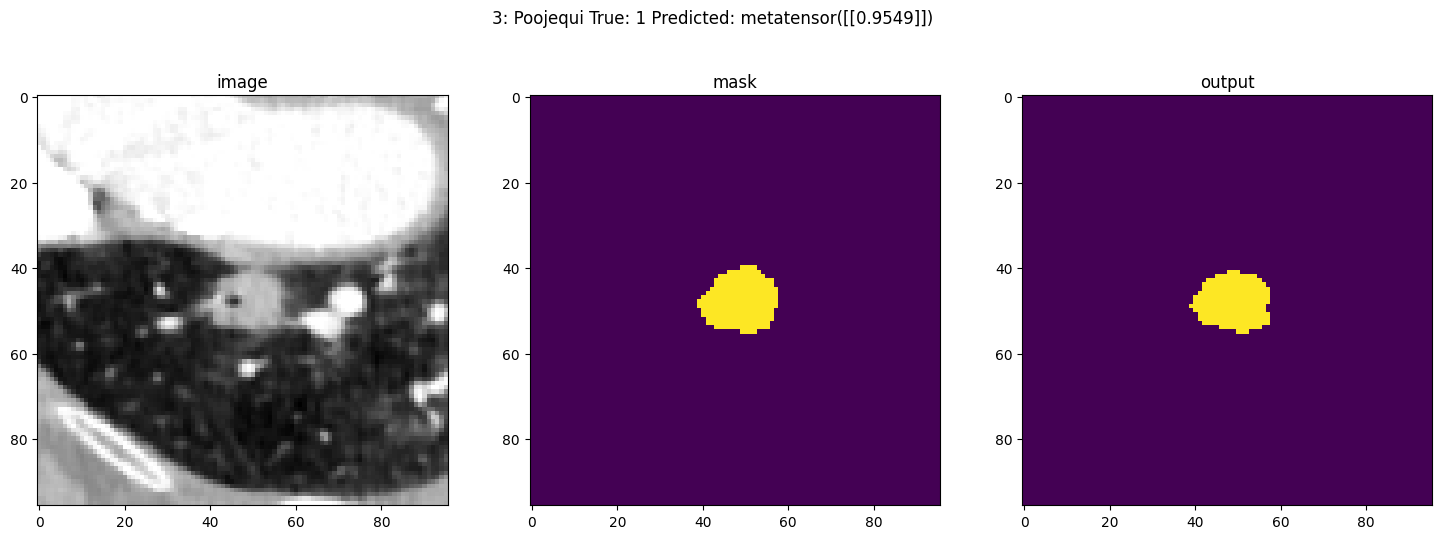

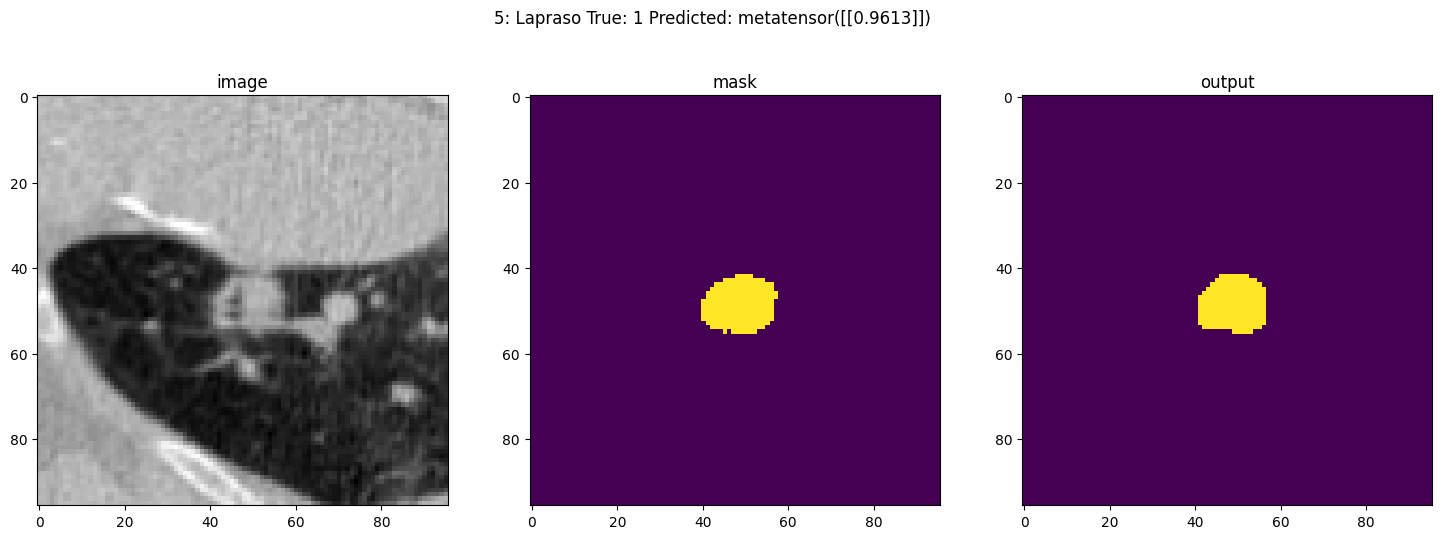

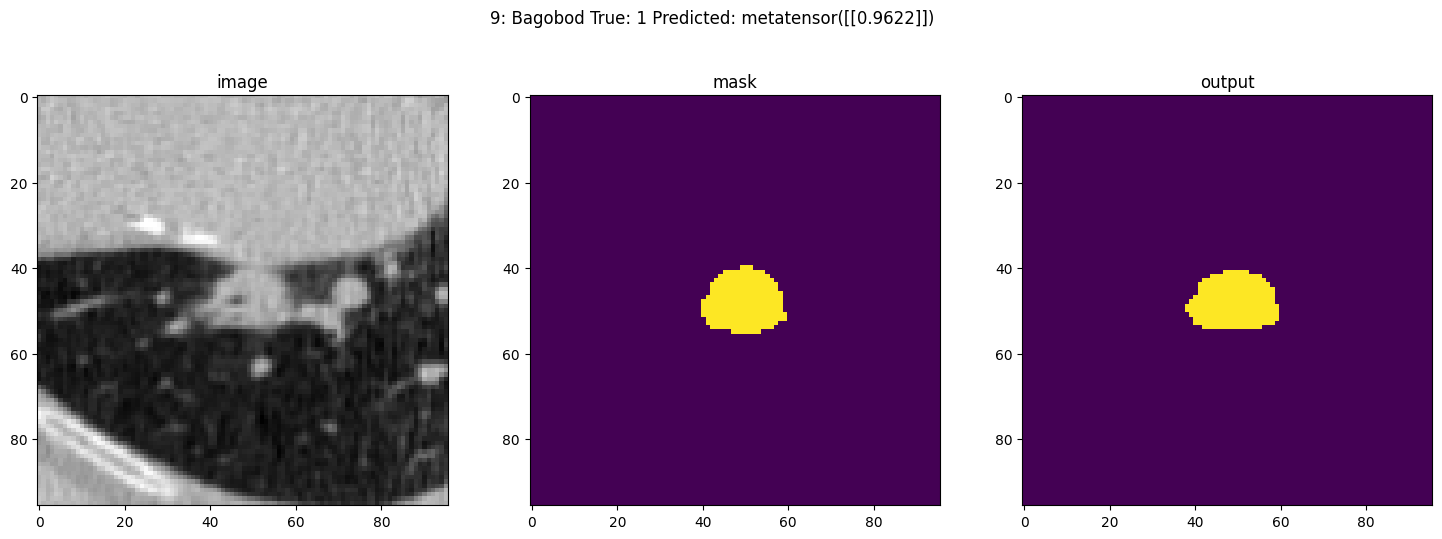

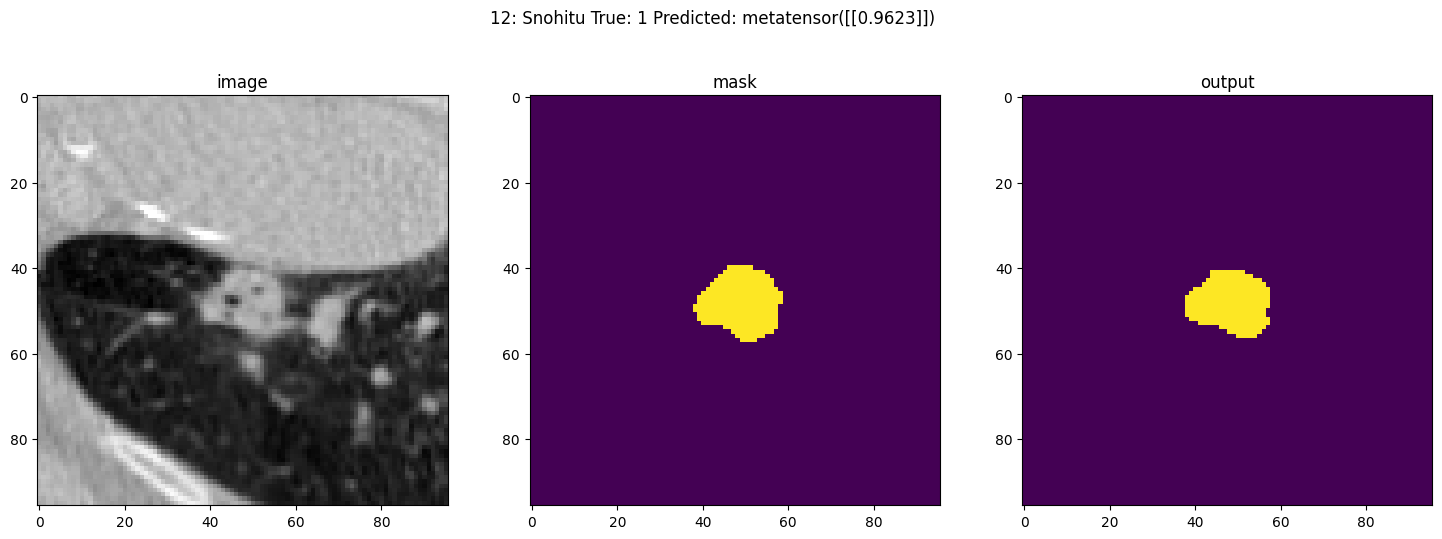

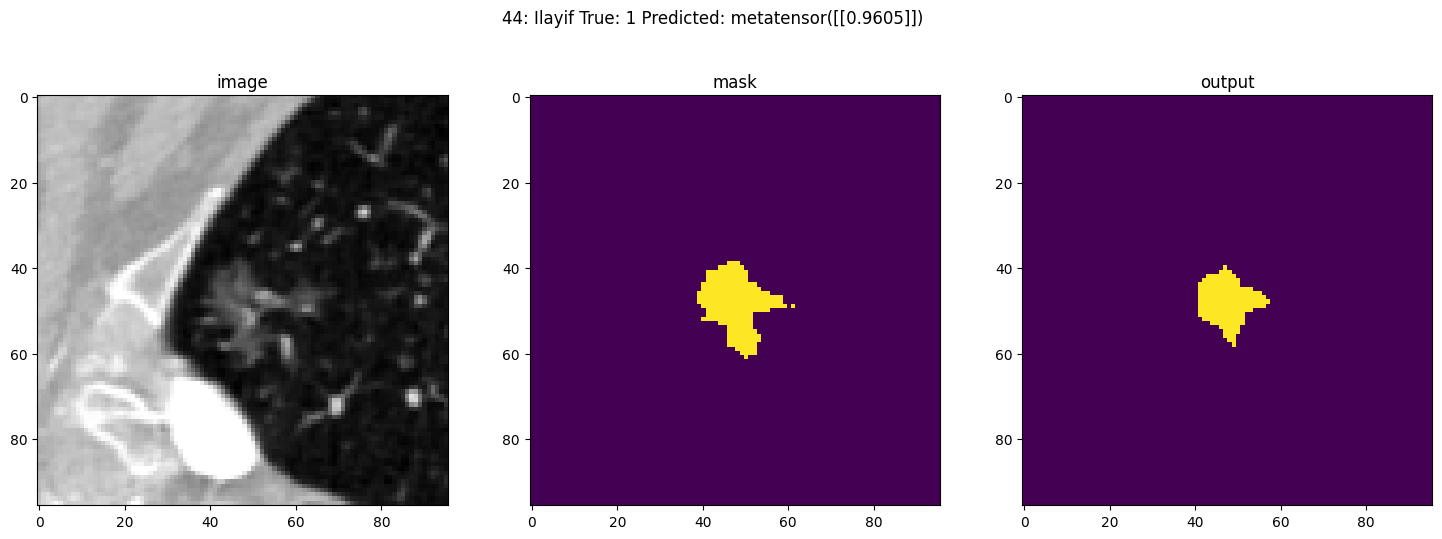

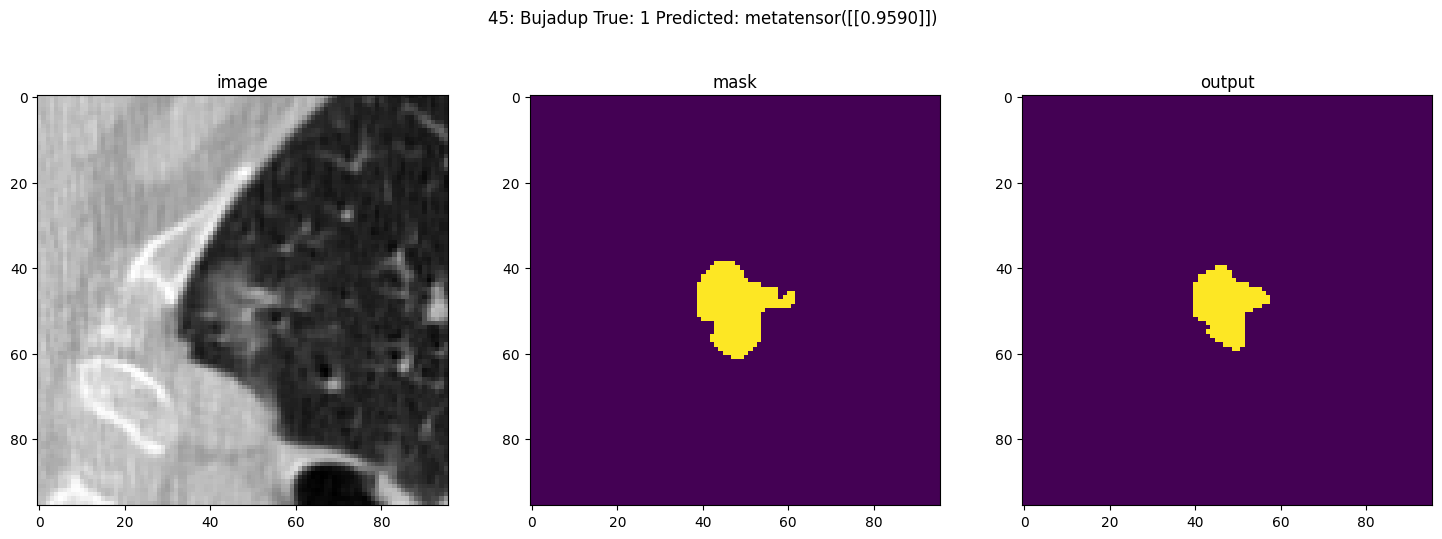

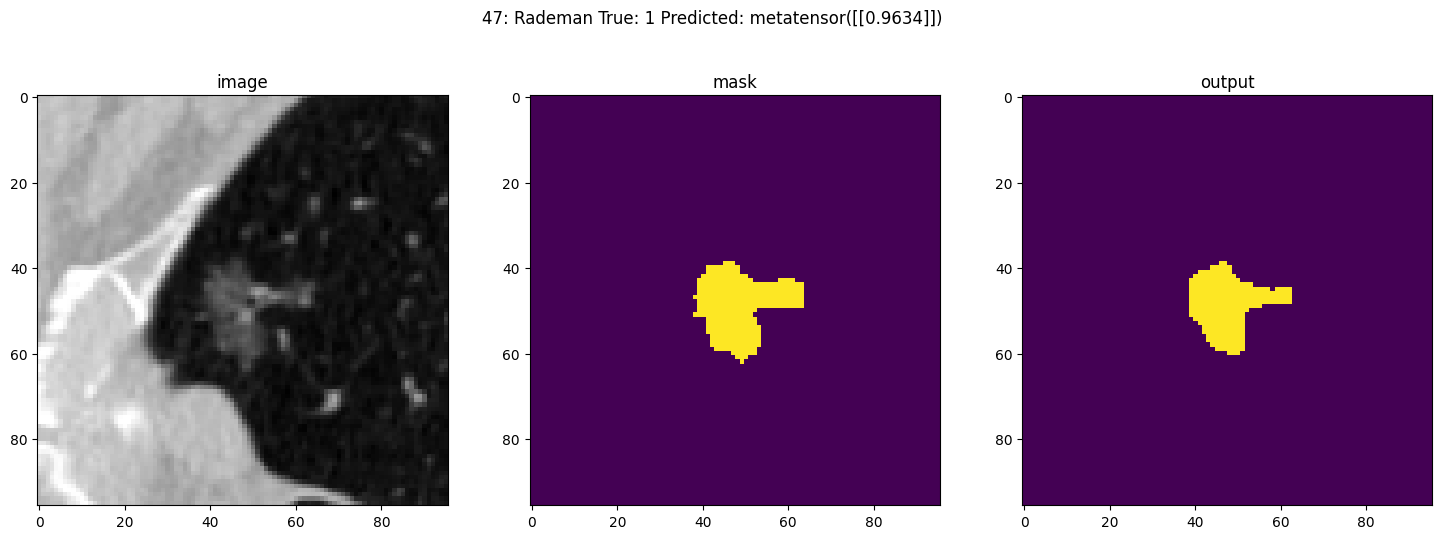

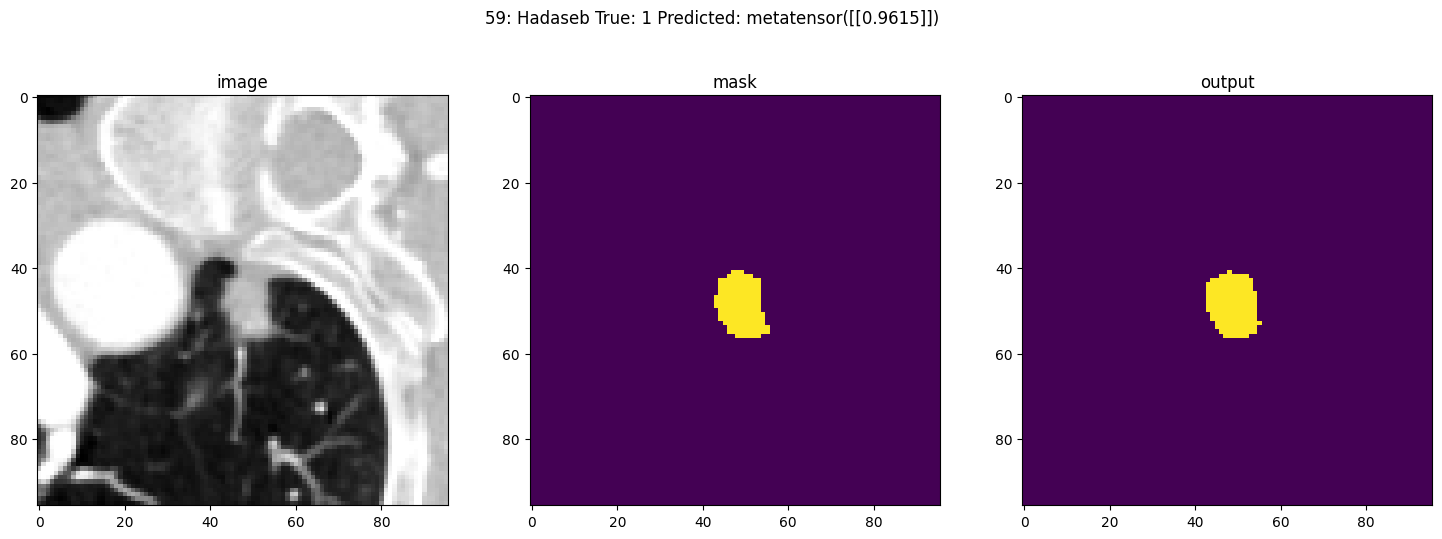

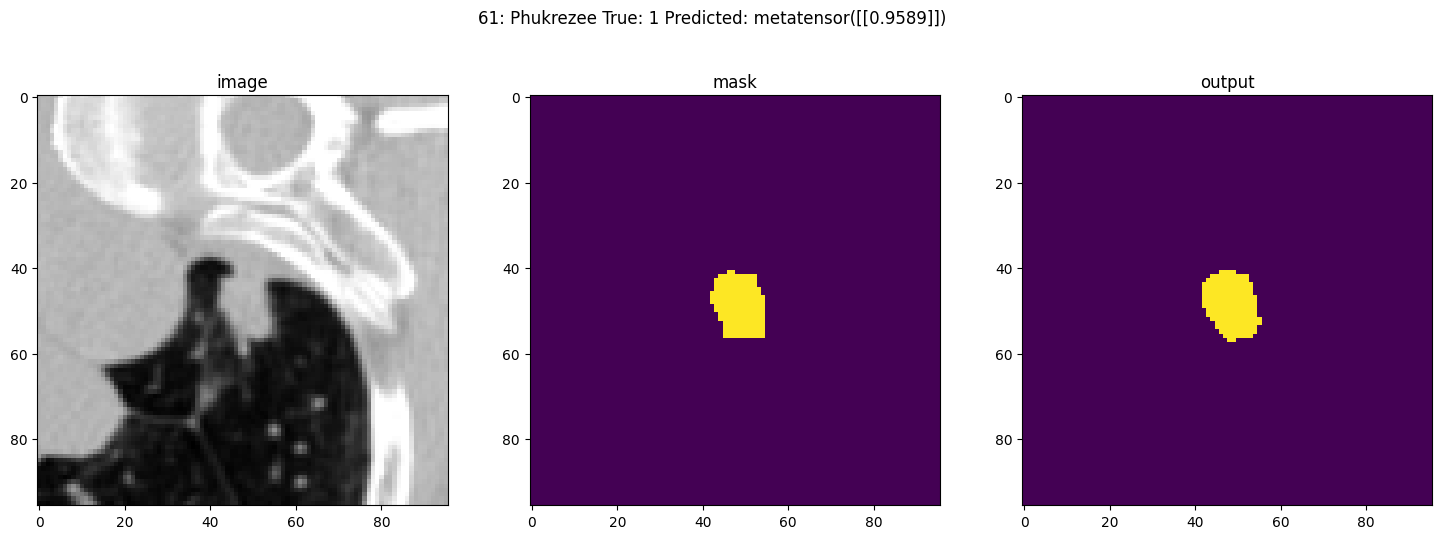

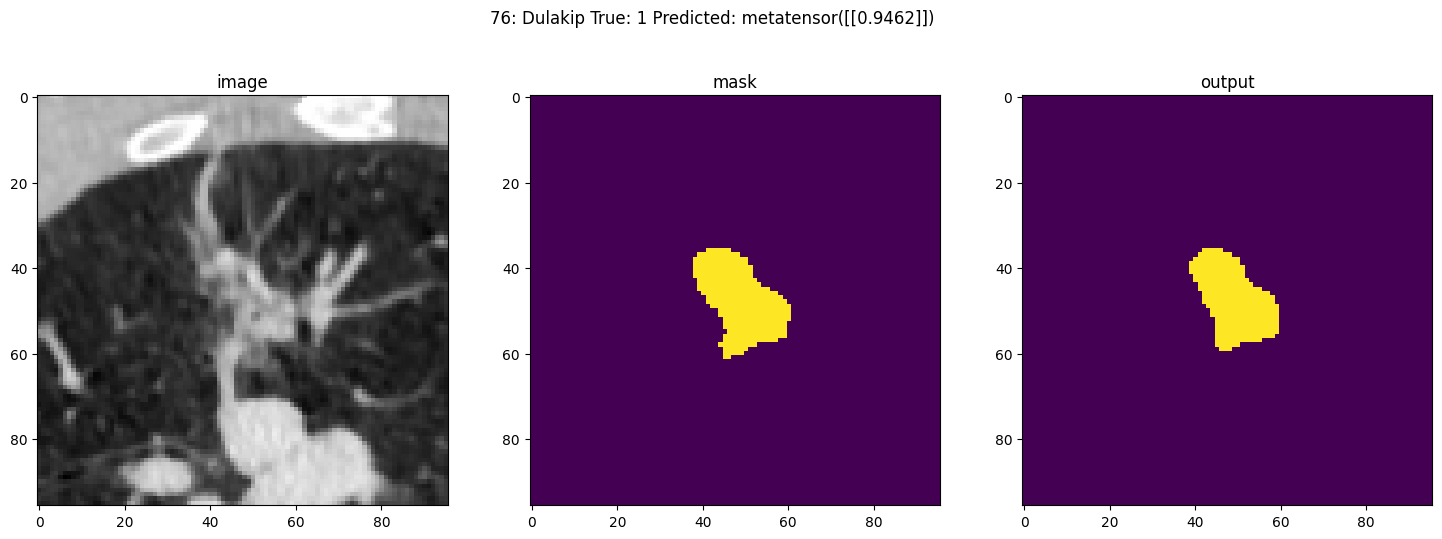

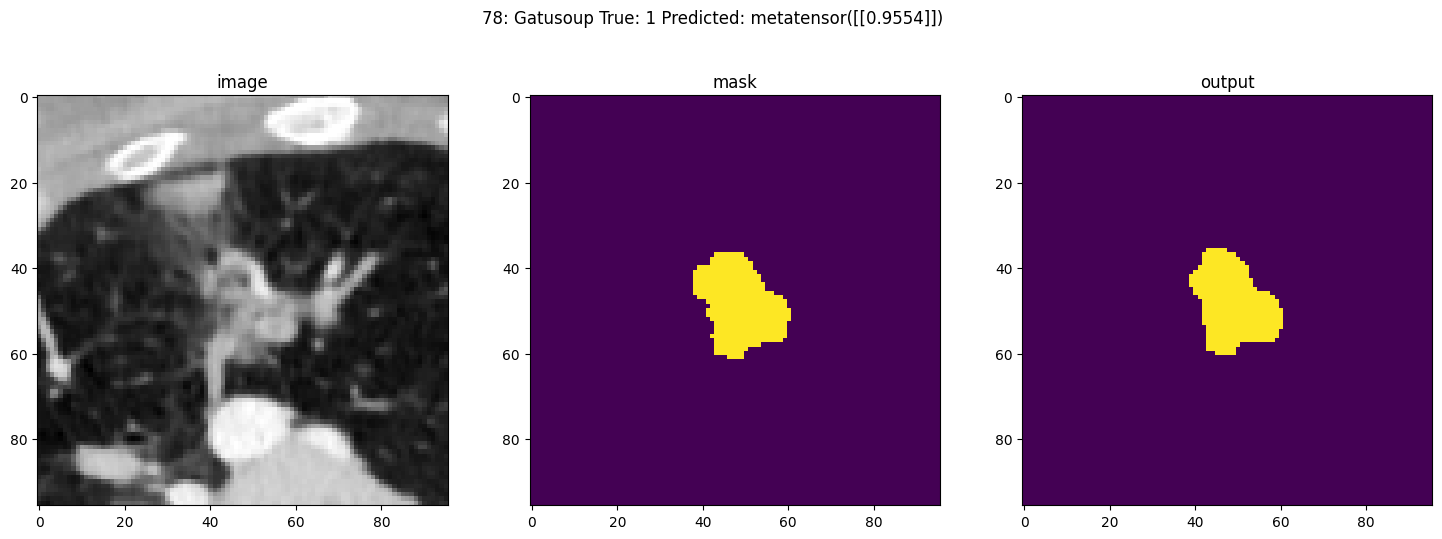

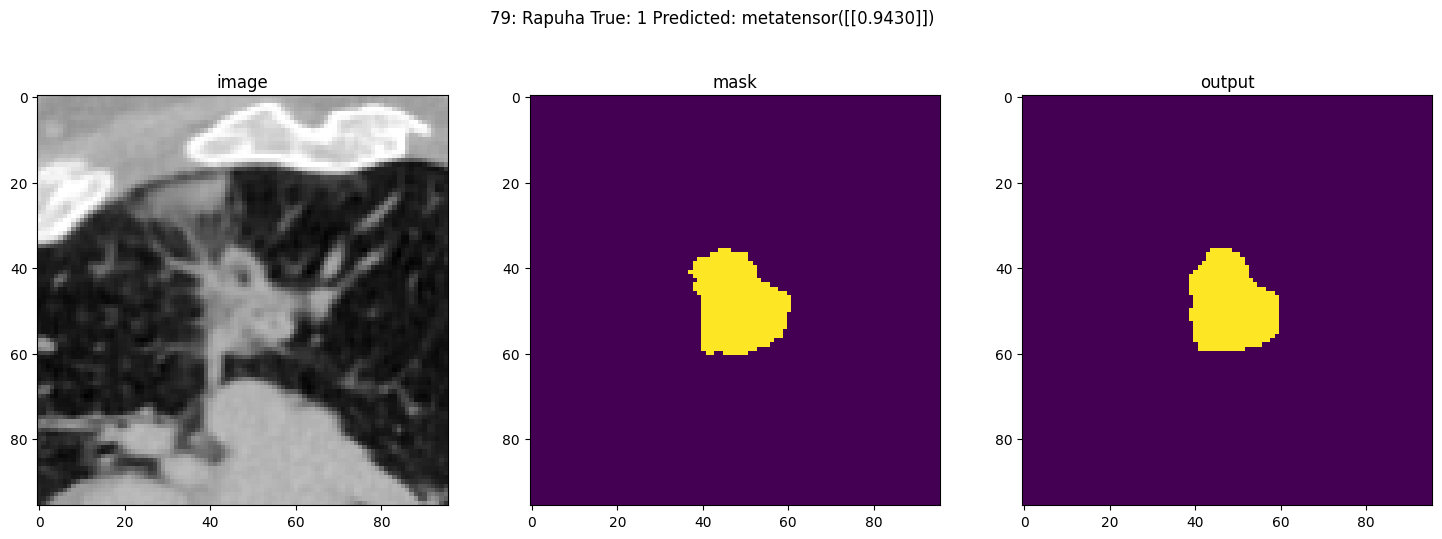

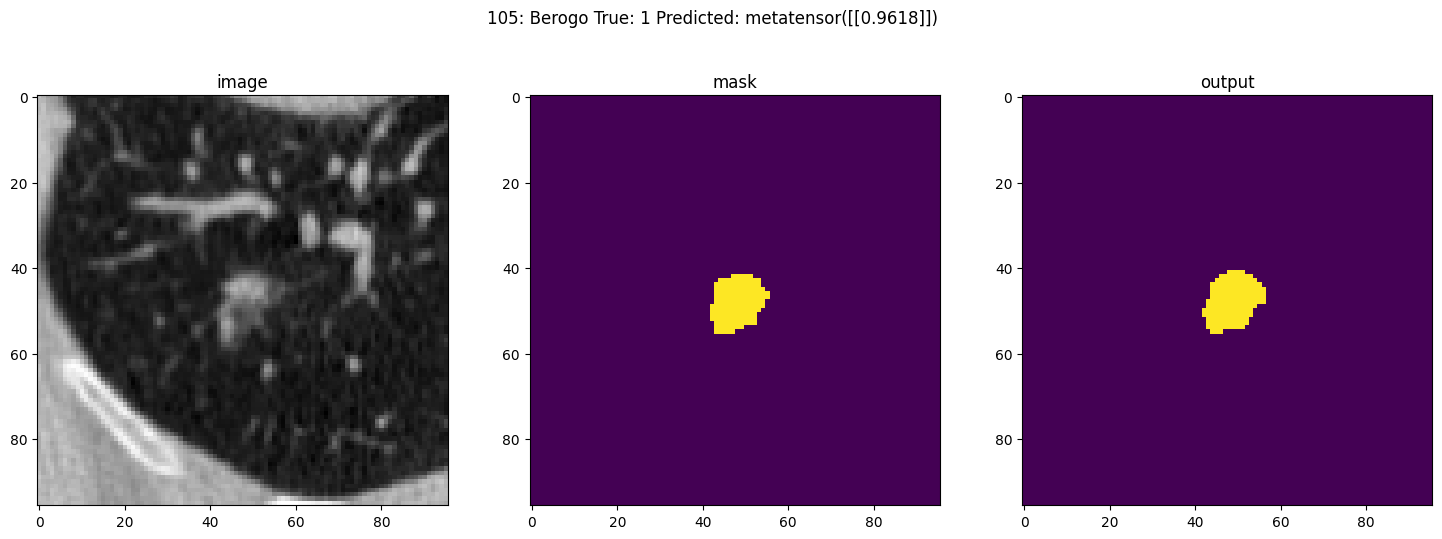

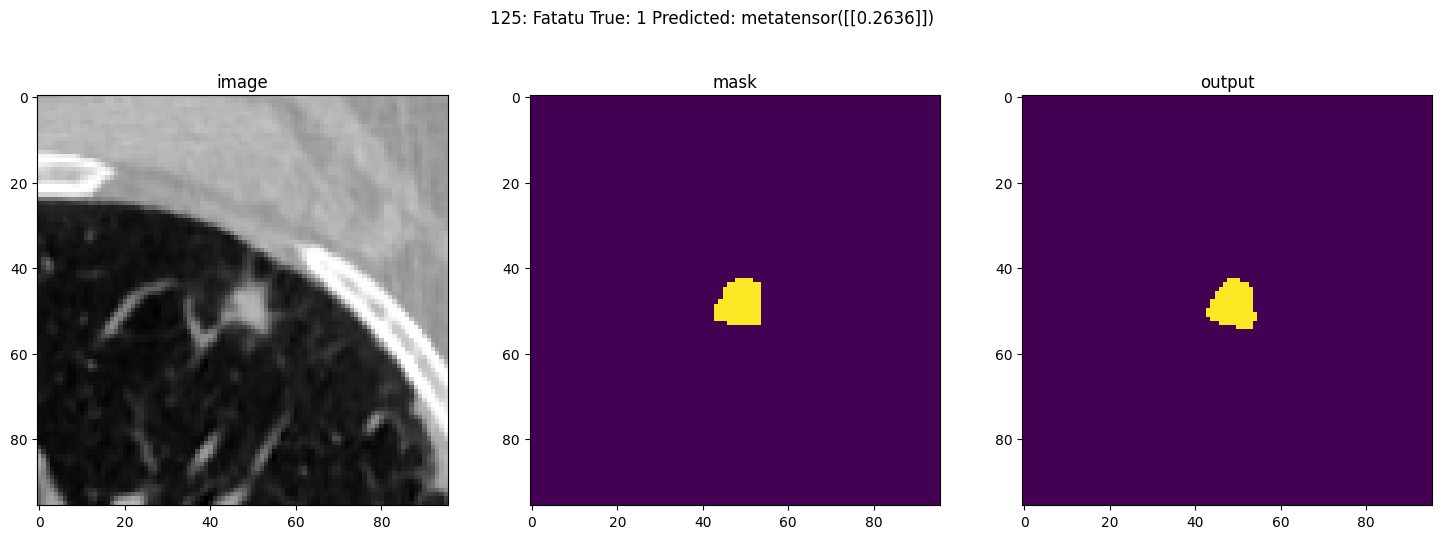

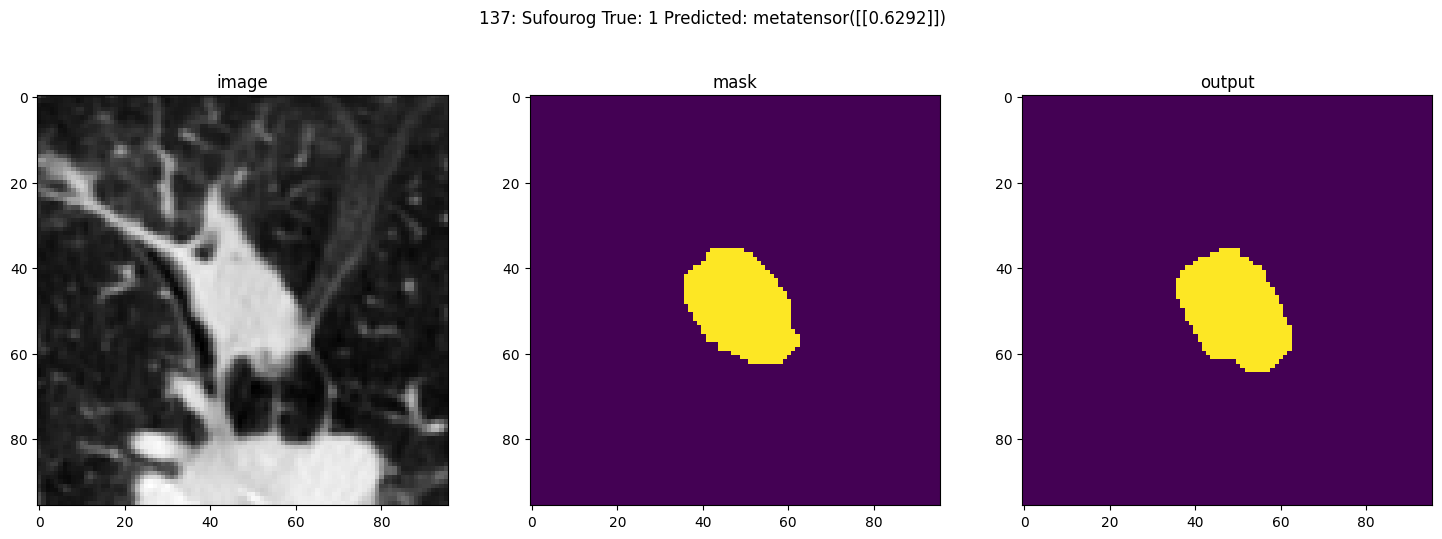

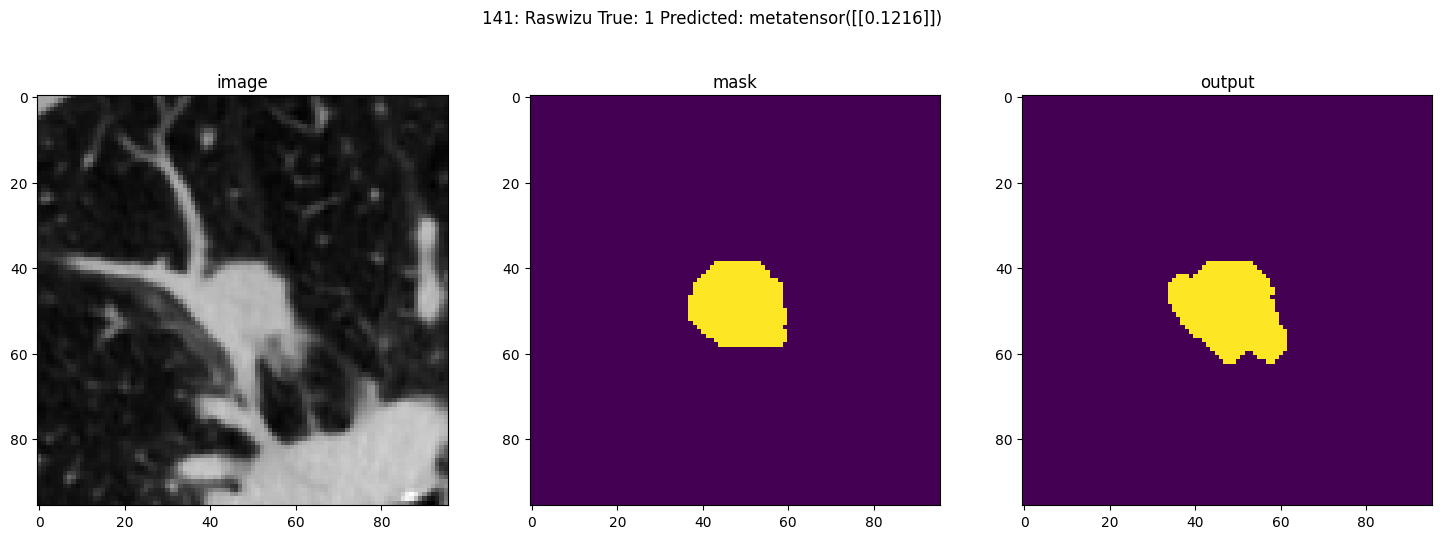

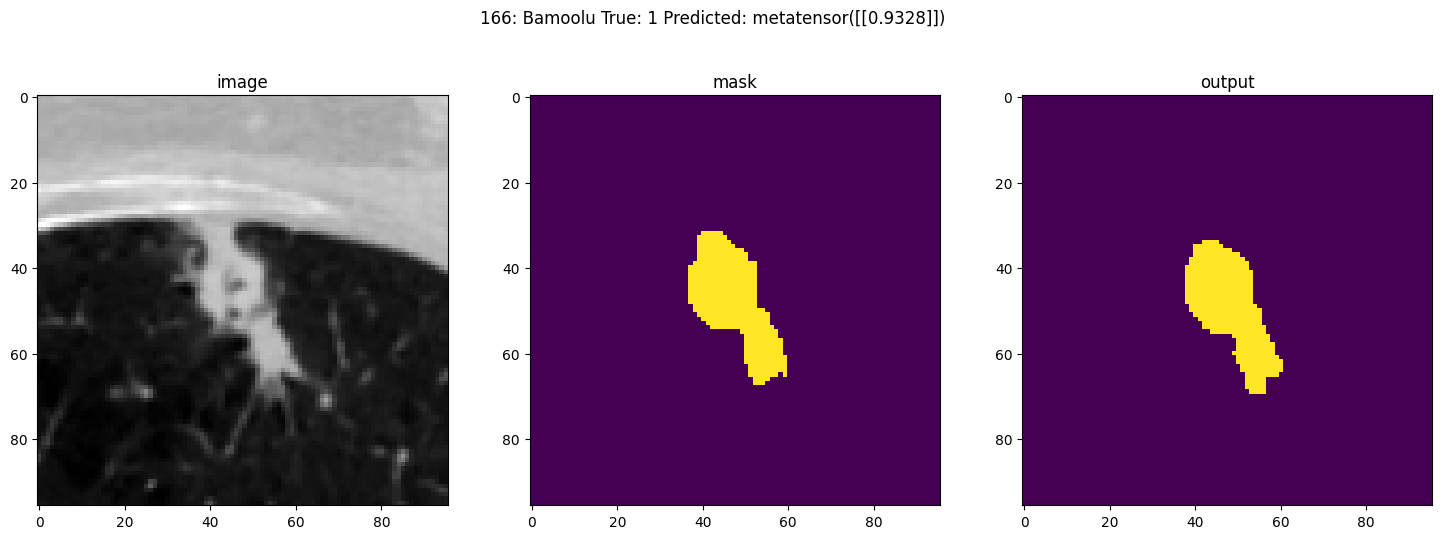

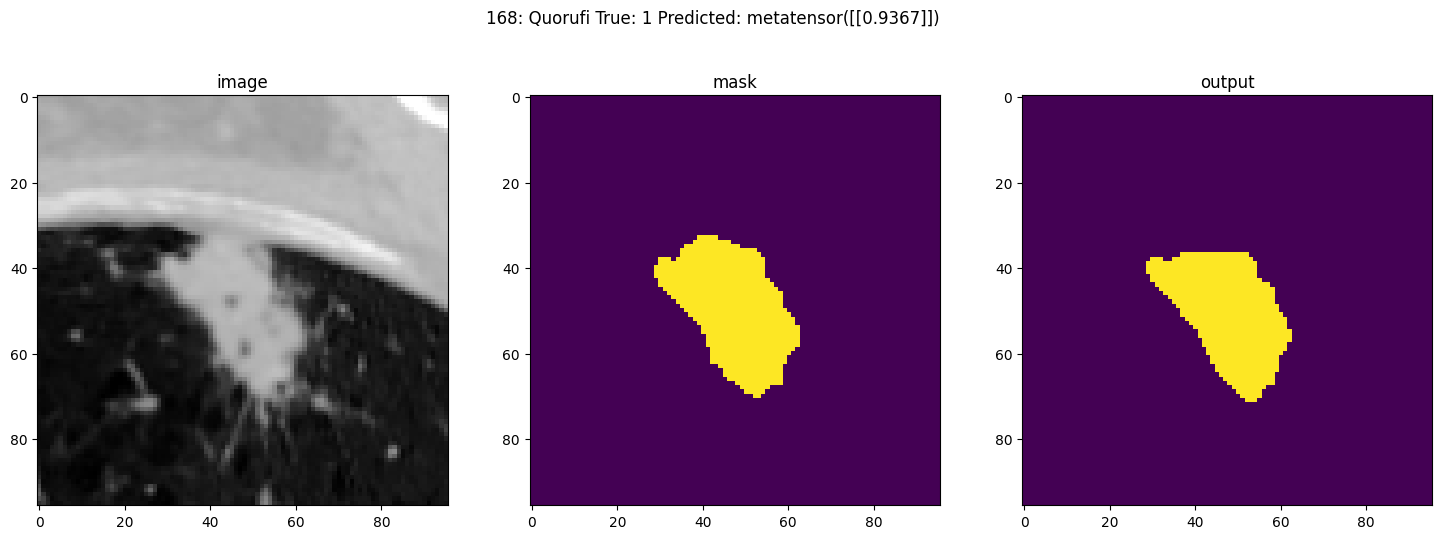

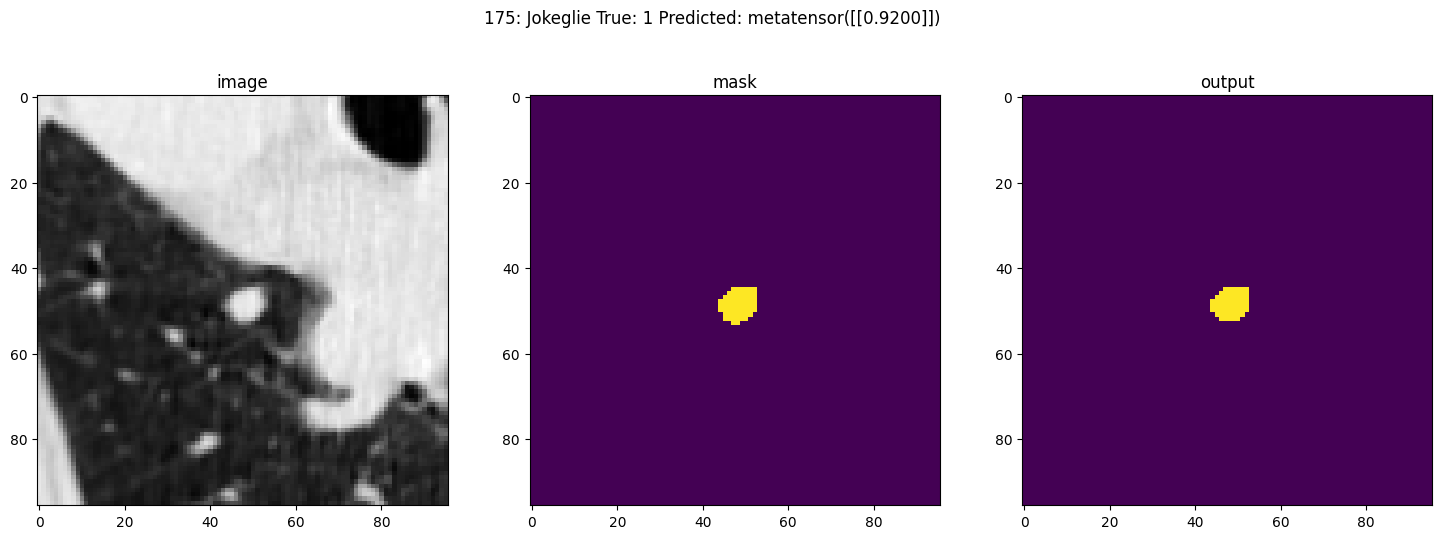

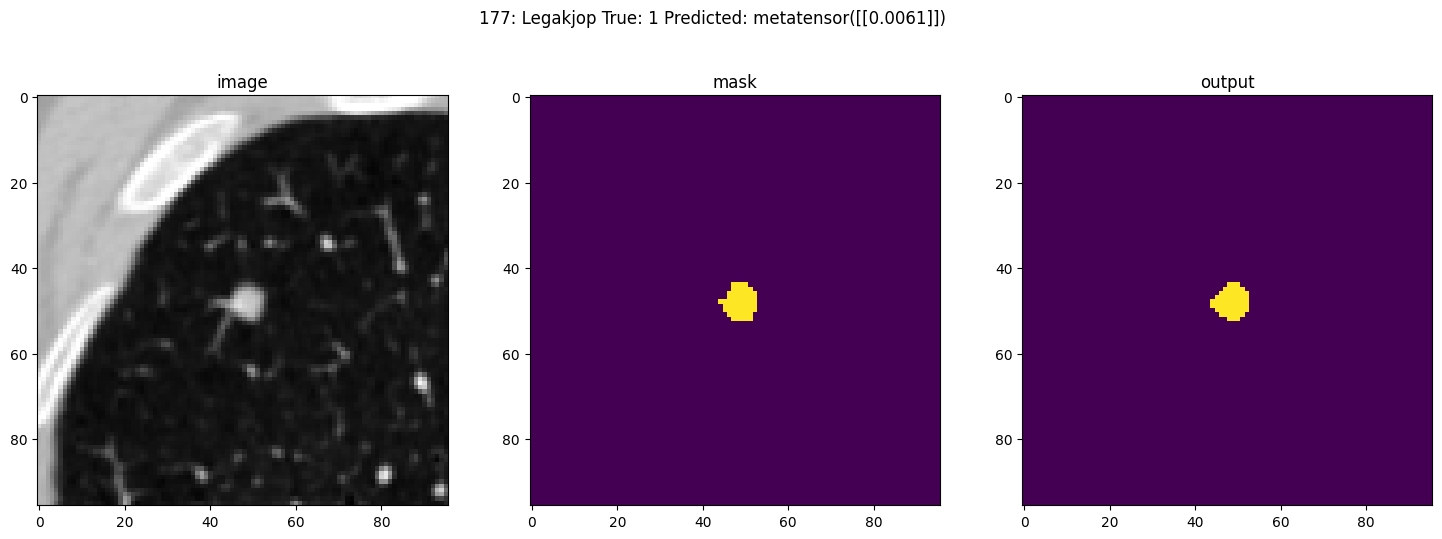

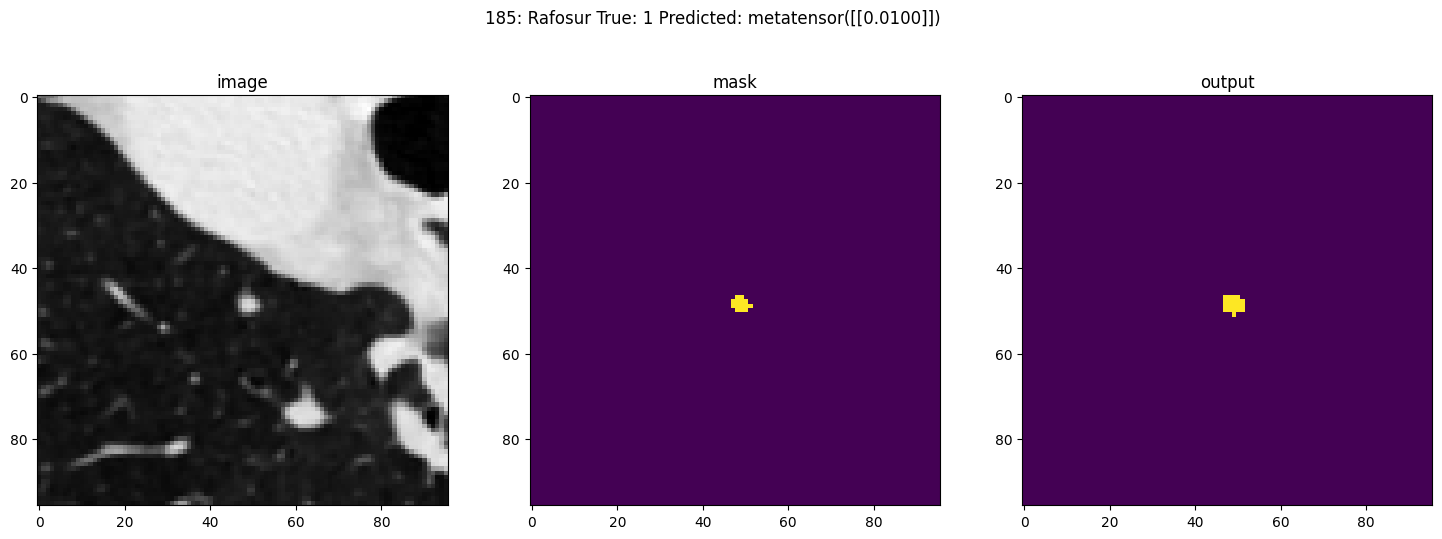

In [39]:

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

display_ds = val_ds

already_seen = []
for case_num in range(0, len(display_ds), 1):
    #print(f"cnt: {case_num}")
    data_case = display_ds[case_num]
    if(int(data_case["label"]) != 1):
        continue

    if(data_case["phonetic_id"] in already_seen):
        continue
    else:
        already_seen.append(data_case["phonetic_id"])

    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval
    already_seen.append(data_case["phonetic_id"])

    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    with torch.no_grad():
        #img_name = os.path.split(data_case["image"].meta["filename_or_obj"])[1]
        # Add title
        img = data_case["image"]
        mask = data_case["mask"]
        label = data_case["label"]
        val_inputs = torch.unsqueeze(img, 1).cuda()
        val_masks = torch.unsqueeze(mask, 1).cuda()
        val_output_mask,val_output_label = model(val_inputs) #sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, img.shape[-1]//2], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("mask")
    plt.imshow(val_masks.cpu().numpy()[0, 0, :, :, mask.shape[-1]//2])
    plt.subplot(1, 3, 3)
    plt.title("output")

    plt.suptitle(str(case_num) + ": " + val_ds[case_num]["phonetic_id"] + " True: " + str(label) + " Predicted: " + str(val_output_label.detach().cpu().float()))
    plt.imshow(torch.argmax(val_output_mask, dim=1).detach().cpu()[0, :, :, mask.shape[-1]//2])
    plt.show()


In [40]:

max_iterations = 30000
eval_num = 1000
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_metric = LossMetric(loss_fn=compute_combined_loss)
roc_auc_metric = ROCAUCMetric()

segmentation_factor = 1


global_step = 0
dice_val_best = 0.0
auc_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

torch.backends.cudnn.benchmark = True
loss_function_mask = DiceCELoss(to_onehot_y=True, softmax=True)
#loss_function_label =  torch.nn.BCELoss()
loss_function_label =  FocalLoss(gamma=2.0) #torch.nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose = True)

scaler = torch.cuda.amp.GradScaler()

def compute_combined_loss(logit_map, logit_label, y_mask, y_label):
    loss = 1*loss_function_mask(logit_map, y_mask)
    loss += 30*loss_function_label(logit_label.float(), y_label.unsqueeze(1).float())
    return loss

def validation(epoch_iterator_val):

    losses = []
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_masks, val_label = (batch["image"].cuda(), batch["mask"].cuda(), batch["label"].cuda())
            
            #with torch.cuda.amp.autocast():
            val_output_mask, val_output_label = model(val_inputs)
            

            val_loss = compute_combined_loss(val_output_mask, val_output_label, val_masks, val_label)
            losses.append(val_loss.item())

            val_masks_list = decollate_batch(val_masks)
            val_masks_convert = [post_label(val_mask_tensor) for val_mask_tensor in val_masks_list]
            
            val_output_mask_list = decollate_batch(val_output_mask)
            val_output_mask_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_output_mask_list]

            predicted_classes = torch.argmax(val_output_mask, dim=1).type(torch.int32).as_tensor().detach().cpu()
            mean_predicted_class = predicted_classes[predicted_classes != 0].float().mean()
            actual_class = torch.max(val_masks).detach().cpu()

            roc_auc_metric( y_pred=val_output_label.squeeze(-1), y=val_label)
            
            dice_metric(y_pred=val_output_mask_convert, y=val_masks_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        mean_auc_val = roc_auc_metric.aggregate().item()
        dice_metric.reset()
        roc_auc_metric.reset()
    return mean_dice_val, mean_auc_val, np.mean(losses)


In [41]:
epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val,auc_val,mean_val_loss = validation(epoch_iterator_val)

print(f"val_loss {mean_val_loss}")
print(f"val_dice {dice_val}")
print(f"val_auc {auc_val}")

Validate (0 / 10 Steps): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.98it/s]

val_loss 4.605817824602127
val_dice 0.8732932806015015
val_auc 0.8920112404656765
